Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). Activity Recognition using Cell Phone Accelerometers, Proceedings of the Fourth International Workshop on Knowledge Discovery from Sensor Data (at KDD-10), Washington DC

In [1]:
!wget http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz

--2024-08-07 10:11:18--  http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Resolving www.cis.fordham.edu (www.cis.fordham.edu)... 150.108.68.29
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz [following]
--2024-08-07 10:11:19--  https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
Connecting to www.cis.fordham.edu (www.cis.fordham.edu)|150.108.68.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404612 (11M) [application/x-gzip]
Saving to: ‘WISDM_ar_latest.tar.gz’

WISDM_ar_latest.tar 100%[===================>]  10.88M  11.3MB/s    in 1.0s    

2024-08-07 10:11:20 (11.3 MB/s) - ‘WISDM_ar_latest.tar.gz’ saved [11404612/11404612]



In [2]:
!ls

sample_data  WISDM_ar_latest.tar.gz


In [3]:
!tar -xvzf  WISDM_ar_latest.tar.gz

WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [4]:
!ls WISDM_ar_v1.1

readme.txt		     WISDM_ar_v1.1_raw.txt	    WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1_raw_about.txt  WISDM_ar_v1.1_trans_about.txt


# Code


In [5]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
# from keras.utils import np_utils

In [6]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  3.4.1


In [7]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
# df = read_data('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
# df = pd.read_csv('WISDM2011.csv')


columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis', 'a1', 'a2','a3', 'a4', 'a5', 'a6']
df = pd.read_csv('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df.drop(['a1', 'a2','a3', 'a4', 'a5', 'a6'], axis=1, inplace=True)
df.head()

<ipython-input-7-72f068a57bf7>:44: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns)


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.50395286;
1,33,Jogging,49106062271000,5.0,11.3,0.95342433;
2,33,Jogging,49106112167000,4.9,10.9,-0.08172209;
3,33,Jogging,49106222305000,-0.6,18.5,3.0237172;
4,33,Jogging,49106332290000,-1.2,12.1,7.205164;


In [8]:
df['z-axis'] = df['z-axis'].str.replace(';','')
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.50395286
1,33,Jogging,49106062271000,5.0,11.3,0.95342433
2,33,Jogging,49106112167000,4.9,10.9,-0.08172209
3,33,Jogging,49106222305000,-0.6,18.5,3.0237172
4,33,Jogging,49106332290000,-1.2,12.1,7.205164


In [9]:
df["z-axis"] = df['z-axis'].astype(float)

In [37]:
df.dtypes

user           int64
activity      object
timestamp      int64
x-axis       float64
y-axis       float64
z-axis       float64
dtype: object

In [38]:
df['activity'].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [39]:
# Describe the data
show_basic_dataframe_info(df)
df.head(5)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098204



,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


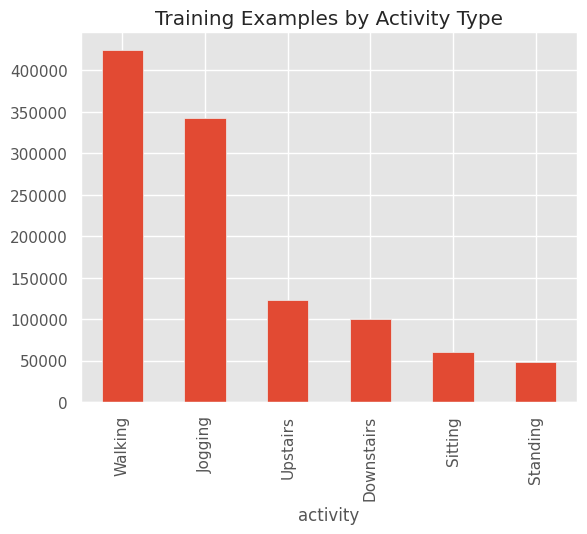

In [10]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()


In [11]:
print (df['activity'].value_counts())

activity
Walking       424398
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64


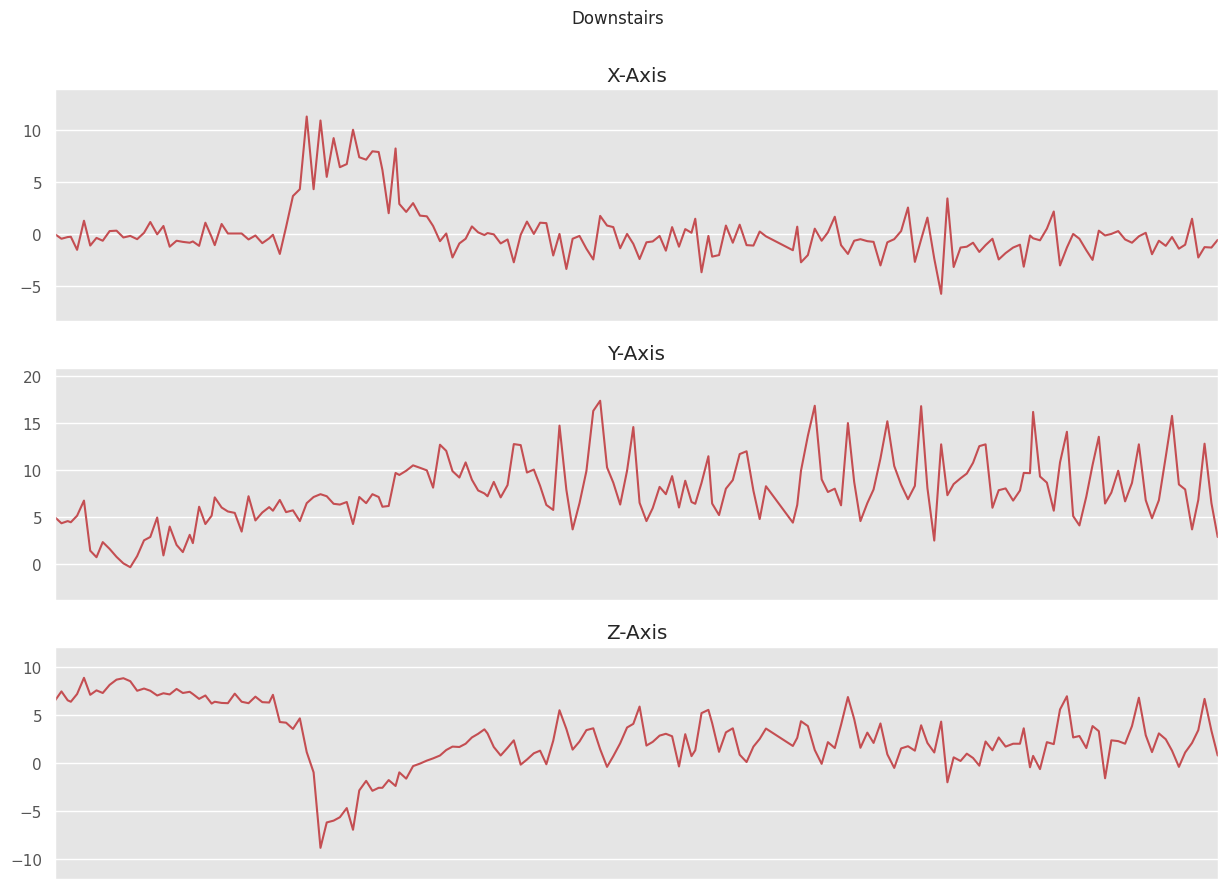

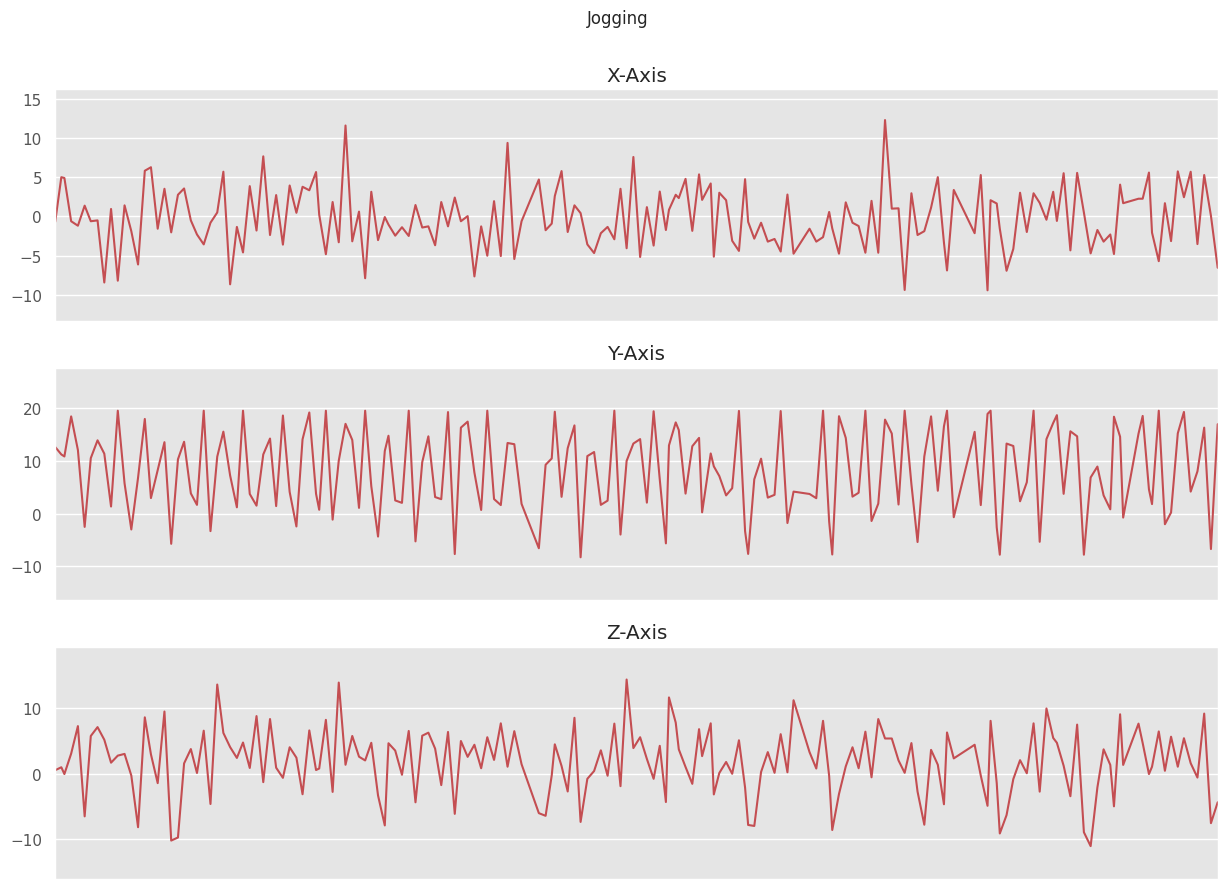

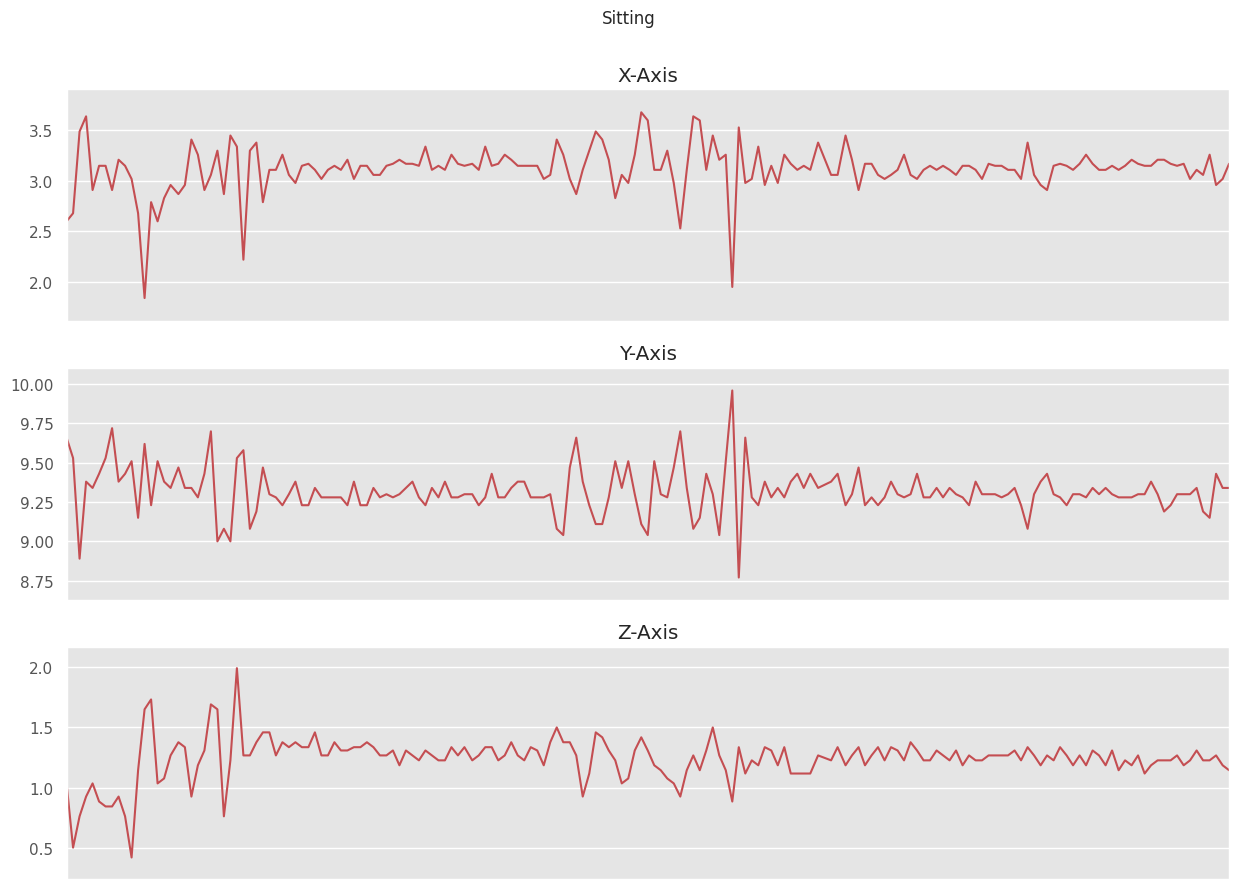

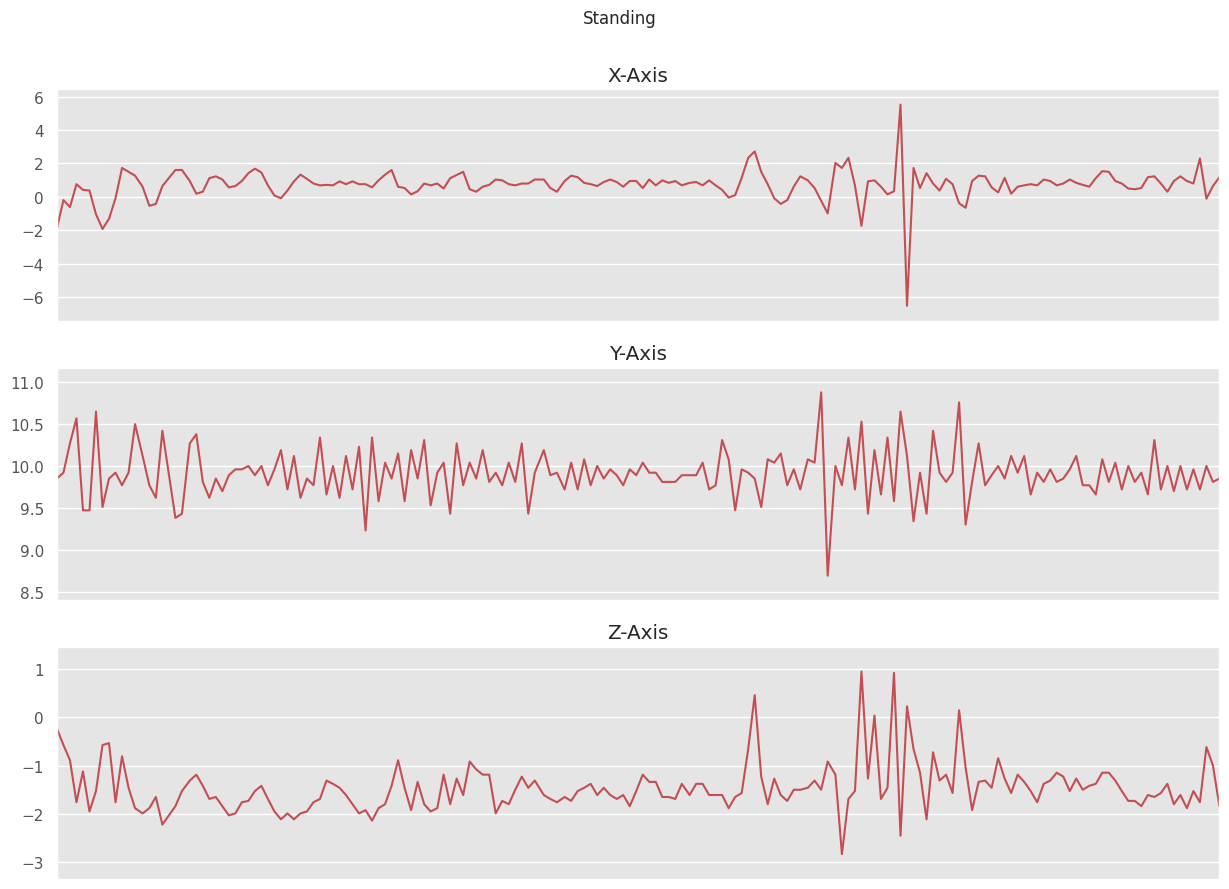

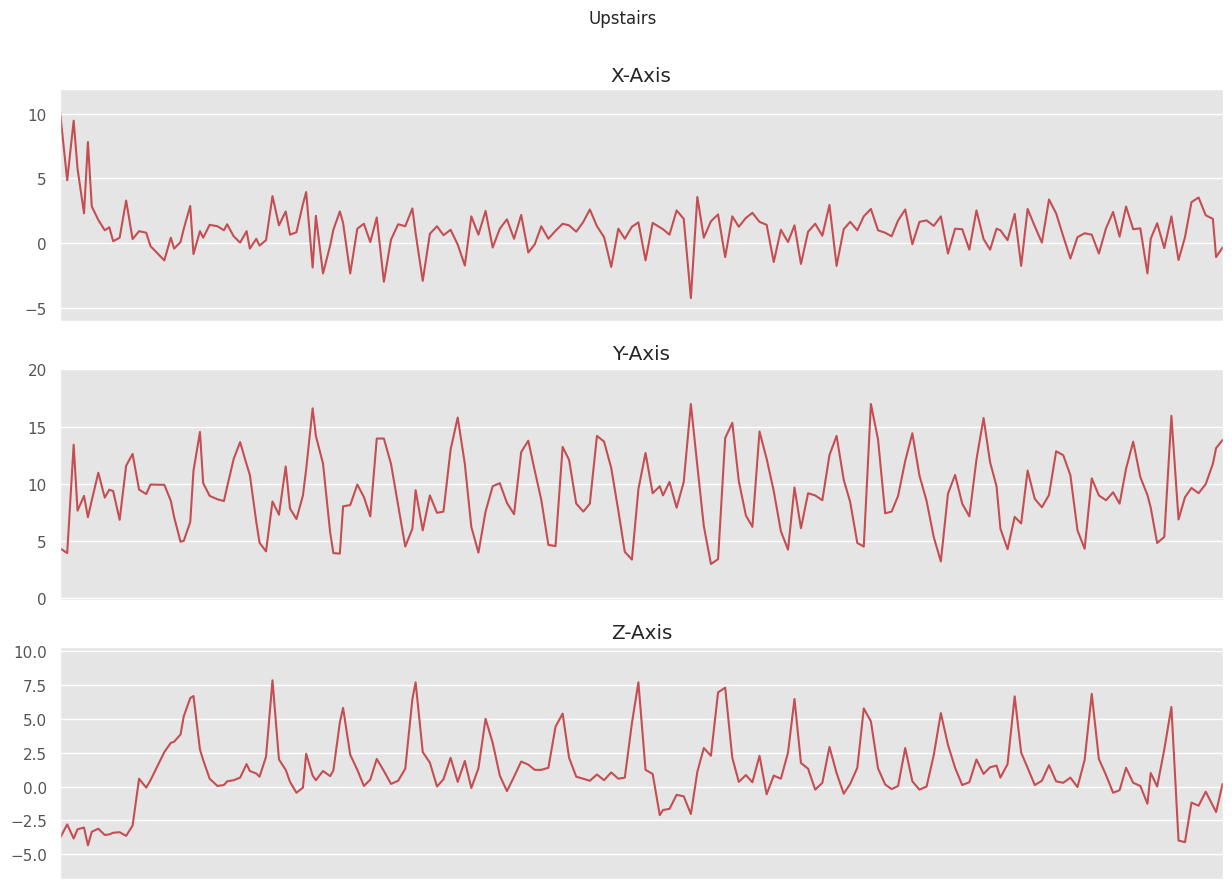

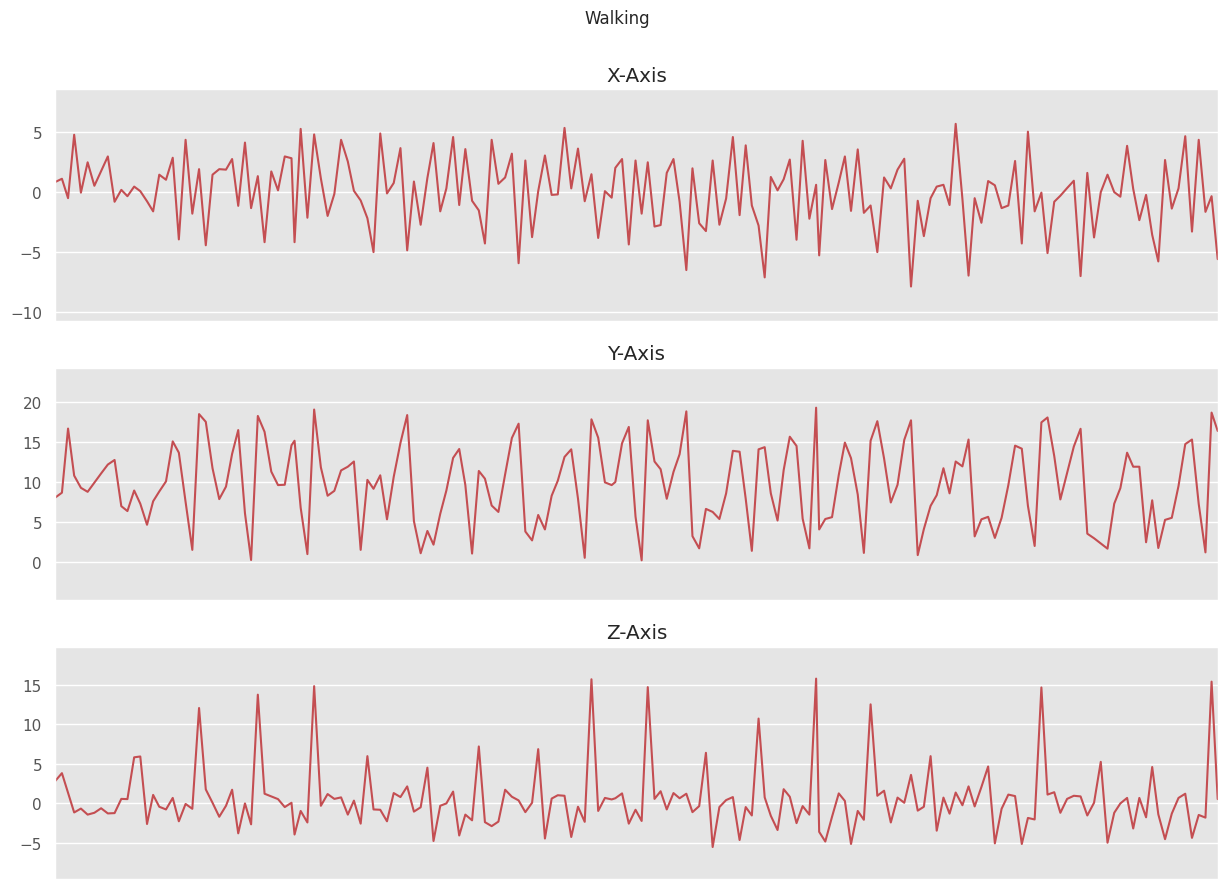

In [12]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [13]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [52]:
#normalizing input variables for entire dataset
pd.options.mode.chained_assignment = None  # default='warn'

df.dropna(subset=['z-axis'], inplace=True)

df['x-axis'] = df['x-axis'] / df['x-axis'].max()
df['y-axis'] = df['y-axis'] / df['y-axis'].max()
df['z-axis'] = df['z-axis'] / df['z-axis'].max()
# Round numbers
df = df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
print(df.isna().sum())

user               0
activity           0
timestamp          0
x-axis             0
y-axis             0
z-axis             0
ActivityEncoded    0
dtype: int64


In [53]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [54]:
# Differentiate between test set and training set
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_data, y_data = create_segments_and_labels(df,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

#df_test = df[df['user-id'] > 28]
#df_train = df[df['user-id'] <= 28]
print (x_data.shape)
print(y_data.shape)

(27454, 80, 3)
(27454,)


In [55]:
print(type(x_data))

<class 'numpy.ndarray'>


In [56]:
#deviding dataset into 70 % (train) and 30% test chuncks
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(19217, 80, 3) (19217,)
(8237, 80, 3) (8237,)


In [57]:
#further saving 15 % from the total of 30 % test data into cross and test
X_cross, X_test, y_cross, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print(X_cross.shape, y_cross.shape)
print(X_test.shape, y_test.shape)

(4118, 80, 3) (4118,)
(4119, 80, 3) (4119,)


In [58]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [59]:
print('X_train shape: ', X_train.shape)
print(X_train.shape[0], 'training samples')
y_train = keras.utils.to_categorical(y_train, num_classes)
print('y_train shape: ', y_train.shape)

X_train shape:  (19217, 80, 3)
19217 training samples
y_train shape:  (19217, 6)


In [60]:
print('X_test shape: ', X_test.shape)
print(X_test.shape[0], 'testing samples')
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_test shape: ', y_test.shape)

X_test shape:  (4119, 80, 3)
4119 testing samples
y_test shape:  (4119, 6)


In [61]:
print('X_cross shape: ', X_cross.shape)
print(X_cross.shape[0], 'cross samples')
y_cross = keras.utils.to_categorical(y_cross, num_classes)
print('y_cross shape: ', y_cross.shape)

X_cross shape:  (4118, 80, 3)
4118 cross samples
y_cross shape:  (4118, 6)


## Model


In [62]:
from keras import models
from keras.models import Model
from keras.layers import Input
import tensorflow
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical

In [63]:
from keras.layers import add
from keras.layers import Activation

In [64]:
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv1D(n_filters,kernel_size=1, padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = Conv1D(n_filters,kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv1D(n_filters,kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
	# activation function
	layer_out = Activation('relu')(layer_out)
	return layer_out

In [65]:
def inception_network(trainX, trainy):
#  verbose, epochs, batch_size = 0, 150, 64
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  input_shape=(n_timesteps,n_features)
  #input to block "a"
  signal_input = Input(shape=input_shape, name='data')
  layer = residual_module(signal_input, 64)
  do=keras.layers.Dropout(rate=0.5)(layer)
  layer = residual_module(do, 64)
  # create model
  globelAverage=keras.layers.GlobalAveragePooling1D(data_format='channels_last')(layer)

  out = Dense(n_outputs, activation='softmax', name='predictions')(globelAverage)

  #rez = Model(inputs=signal_input, outputs=out)
  model = Model(inputs=signal_input, outputs=out)

  return model

In [79]:
model=inception_network(X_train, y_train)

In [80]:
print (model)
model.summary()

<Functional name=functional_2, built=True>


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 80, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 80, 64)         │            640 │ data[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 80, 64)         │         12,352 │ conv1d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 80, 64)         │            256 │ data[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 80, 64)         │              0 │ conv1d_12[0][0],       │
│                           │                        │                │ conv1d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 80, 64)         │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 80, 64)         │              0 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 80, 64)         │         12,352 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 80, 64)         │         12,352 │ conv1d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 80, 64)         │              0 │ conv1d_14[0][0],       │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 80, 64)         │              0 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ activation_5[0][0]     │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ predictions (Dense)       │ (None, 6)              │            390 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,342 (149.77 KB)

 Trainable params: 38,342 (149.77 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
inception= model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

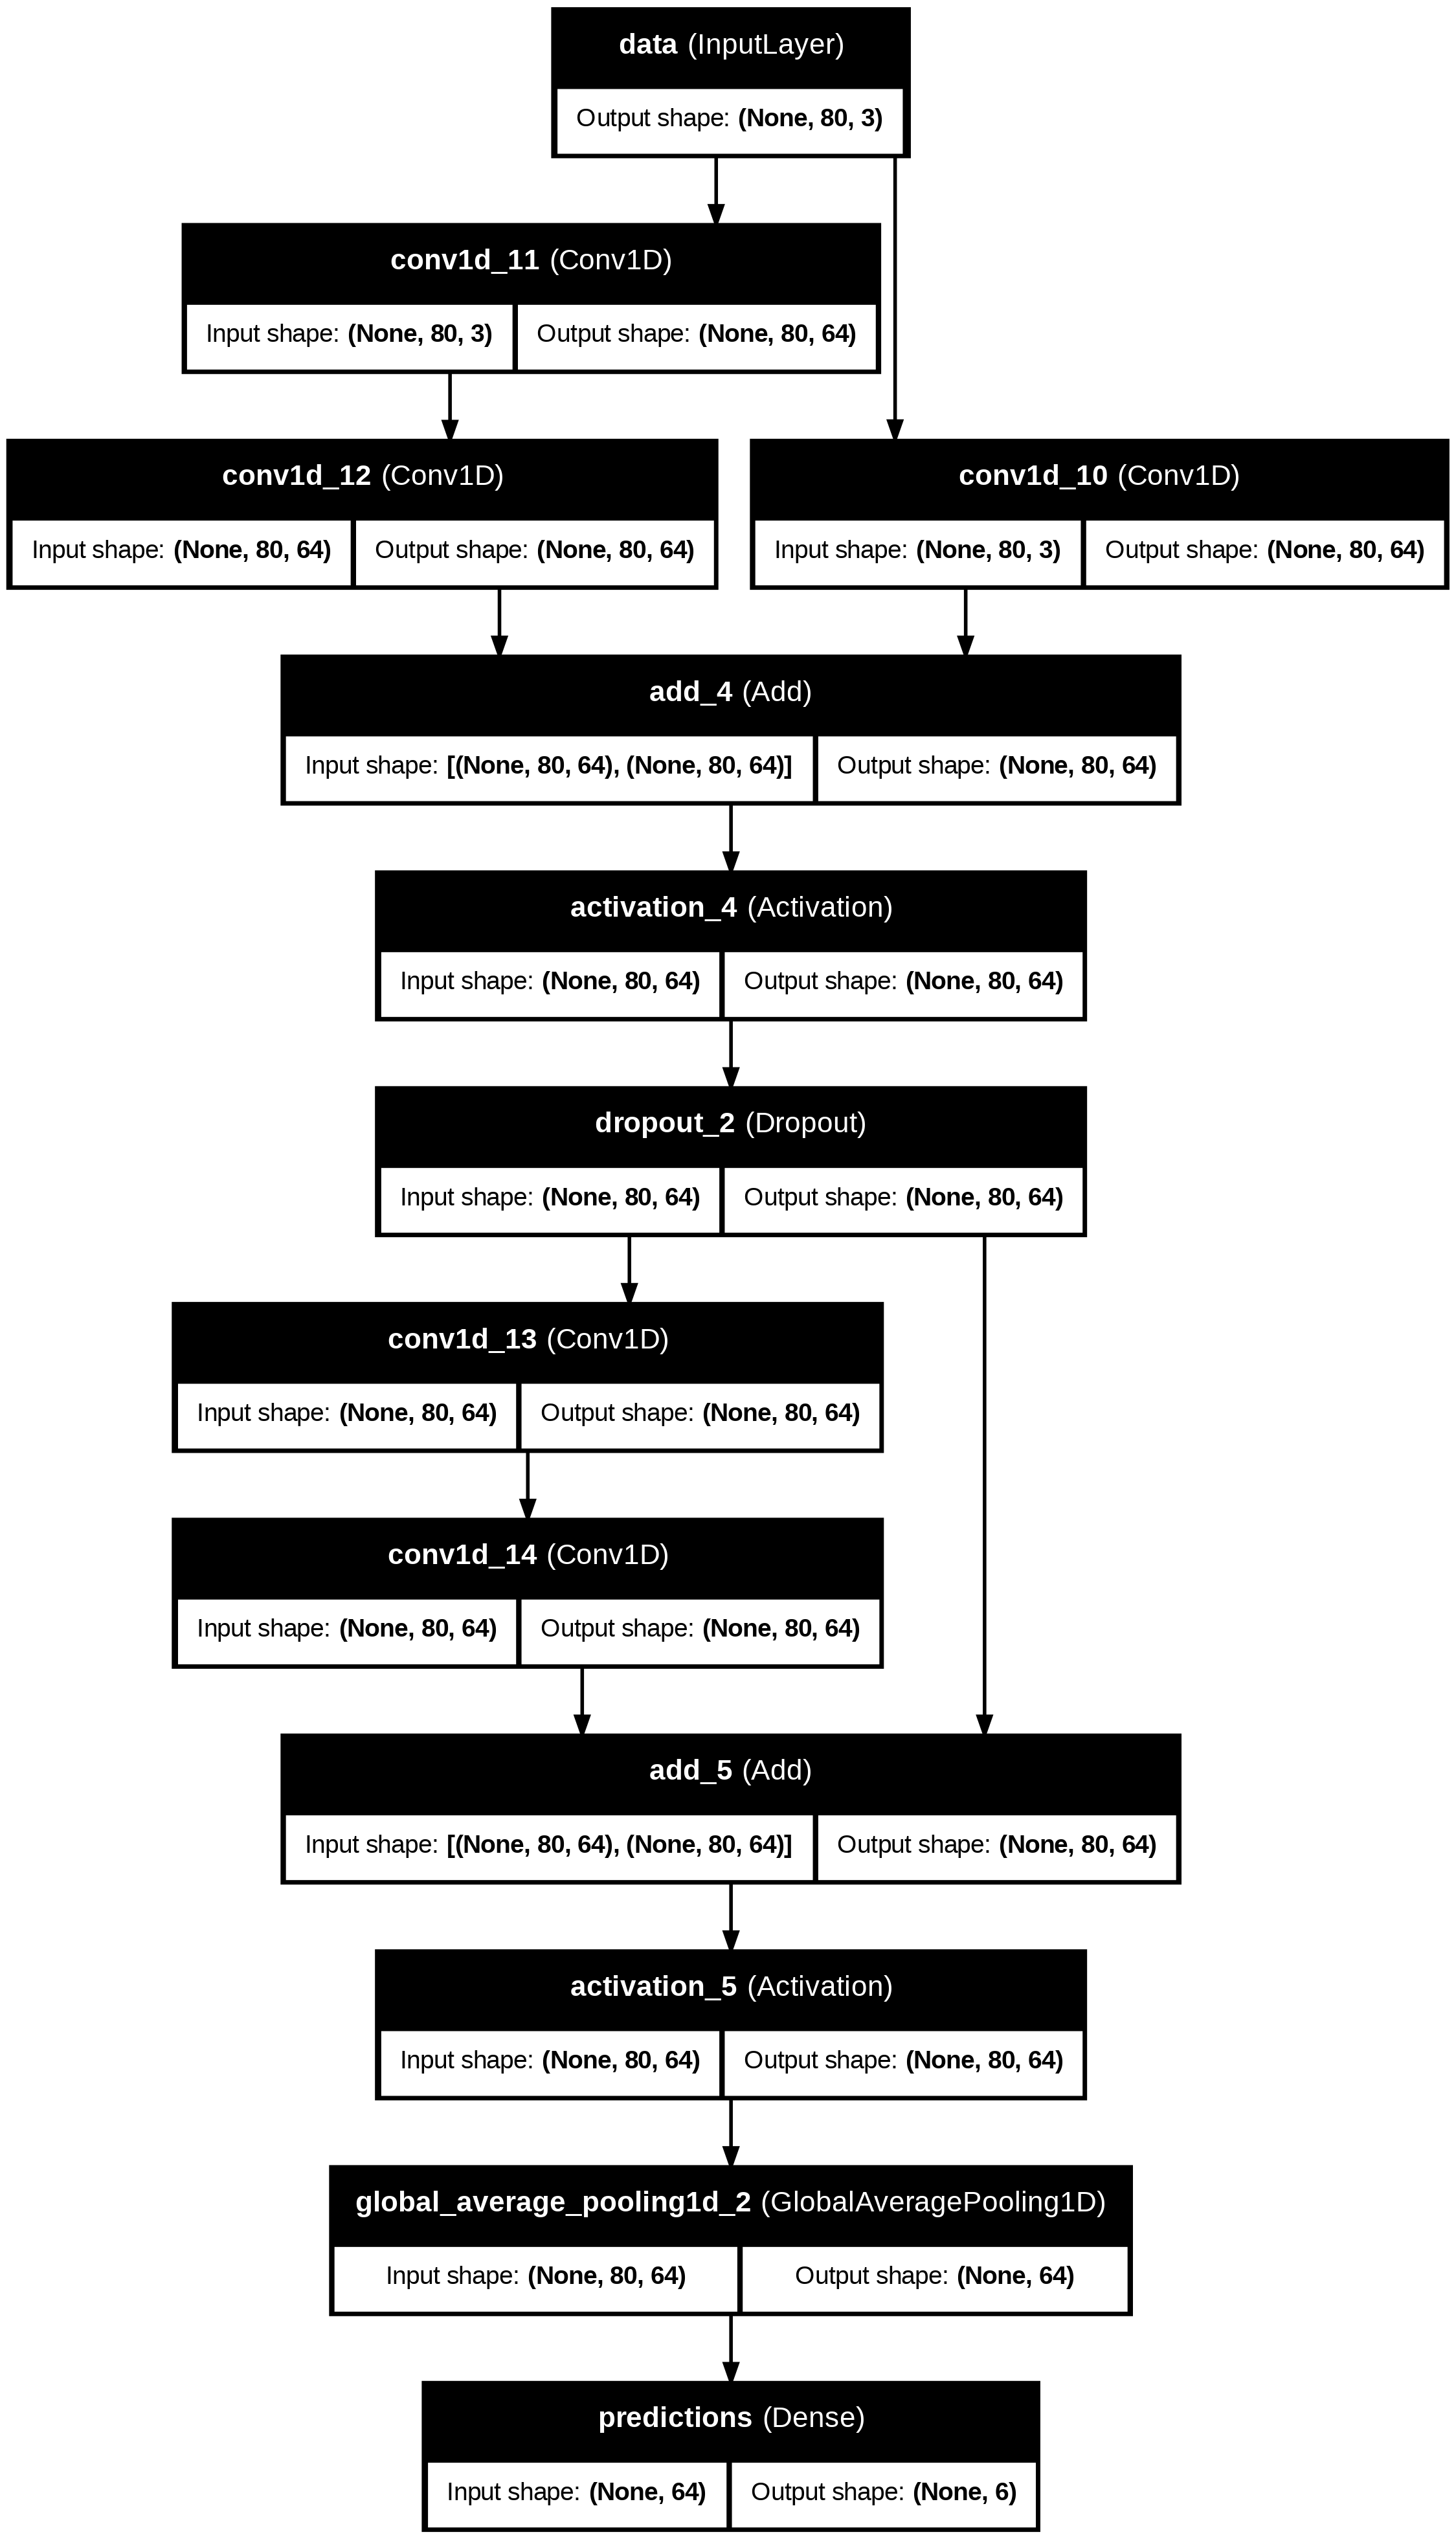

In [82]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [83]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,verbose=1)

In [84]:
X_train.shape, y_train.shape

((19217, 80, 3), (19217, 6))

In [85]:
verbose, epochs, batch_size = 0, 150, 120 # here are the parameters of training verbose, epoch, batchSize
history=model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1,callbacks=[es])
# evaluate model

Epoch 1/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6027 - loss: 1.1553 - val_accuracy: 0.7652 - val_loss: 0.6267
Epoch 2/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7646 - loss: 0.6279 - val_accuracy: 0.8055 - val_loss: 0.5196
Epoch 3/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8025 - loss: 0.5268 - val_accuracy: 0.8167 - val_loss: 0.4770
Epoch 4/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8228 - loss: 0.4682 - val_accuracy: 0.8461 - val_loss: 0.4059
Epoch 5/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8406 - loss: 0.4253 - val_accuracy: 0.8473 - val_loss: 0.4178
Epoch 6/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8549 - loss: 0.3987 - val_accuracy: 0.8485 - val_loss: 0.4145
Epoch 7/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8677 - loss: 0.3696 - val_accuracy: 0.8842 - val_loss: 0.3208
Epoch 8/150
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8784 - loss: 0.3382 - val_acc

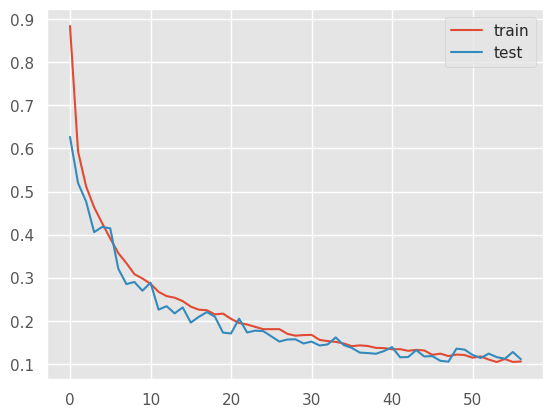

In [87]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

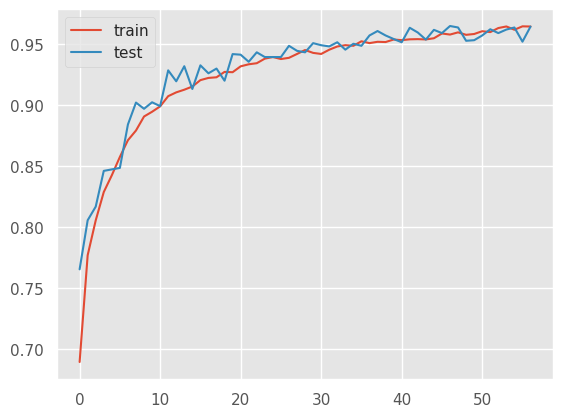

In [88]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [89]:
_, accuracy = model.evaluate(X_cross, y_cross, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  96.64885997772217


In [90]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  96.4554488658905


In [91]:
labels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [92]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(6, 6))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cmap="RdYlGn",cbar_kws={"shrink": 0.8})
    return ax

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Axes: >

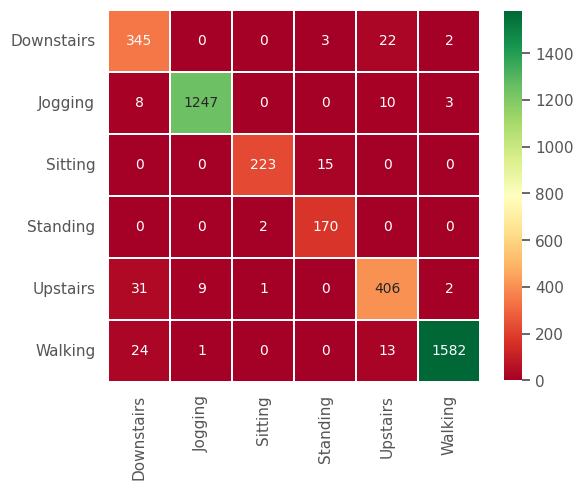

In [93]:
y_pred=model.predict(X_test)
plot_confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

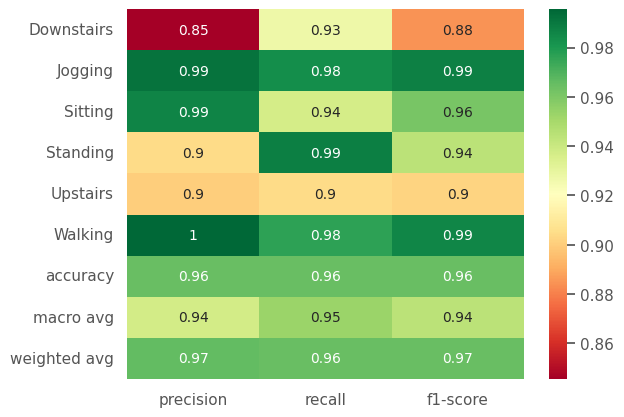

In [94]:
from sklearn.metrics import classification_report
import seaborn as sns
y_pred=model.predict(X_test)
report= classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1),target_names=labels,output_dict=True)
#print (report)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T,cmap="RdYlGn", annot=True)